# iTunes music library analysis: Novelty Detection
This is the 4th post in a series of posts devoted to analysis of iTunes music library using Scikit-Learn tools.   
The purpose of the analysis is to detect tracks in my iTunes music library that would suit my fitness practices, which are "cycling", "yoga", and "ballet". To solve that problem I use machine learning classification algorithms.    

The previous posts cover the following steps:
1. [00_Summary](http://localhost:8888/notebooks/00_Summary.ipynb) — Summary of this analysis, its goals and methods, installation notes.
2. [01_Data_preparation](http://localhost:8888/notebooks/01_Data_preparation.ipynb) — Data gathering and cleaning.
3. [02_Data_visualisation](http://localhost:8888/notebooks/02_Data_Visualisation.ipynb) — Visualisation and overview of data.
4. [03_Preprocessing](http://localhost:8888/notebooks/03_Preprocessing.ipynb) — Data preprocessing to use it as input for Scikit-learn machine learning algorithms.

As a result of previous manipulations I have two databases (DBs): 
* training DB contains 88 tracks labeled with one of the three classes: "ballet", "cycling", "yoga";
* test DB contains 444 non-labeled tracks. 

The three classes I have in the training set don't cover all classes of music I have in my iTunes music library (test DB). Because of that I can't apply a classification algorithm to the whole test set as it will also assign irrelevant tracks to some class.  

In the following notebook I'm going to identify tracks in the unlabeled dataset that fit classes in the training dataset and eliminate tracks that completely unfit the classes. In the first part, part 'a', of the notebook I will provide the algorithm with the whole training dataset — with the three classes at once — to choose the boundary. In the 'b' part of the notebook I will provide the algorithm only with one class at a time. In the end I will compare the results of both approaches.  

As a shortcut, in this notebook I import module "data_processing" where I perform steps from the [01_Data_preparation](http://localhost:8888/notebooks/01_Data_preparation.ipynb) and [03_Preprocessing](http://localhost:8888/notebooks/03_Preprocessing.ipynb) notebooks.  
I start with importing the modules required in the following notebook.

In [141]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import numpy as np
from sqlitedict import SqliteDict

# import my module from the previous notebook
import data_processing as prs

# set seaborn plot defaults
import seaborn as sns; 
sns.set(palette="husl")
sns.set_context("notebook")
sns.set_style("ticks")

# format floating point numbers
# within pandas data structures
pd.set_option('float_format', '{:.2f}'.format)

## Preprocessing data

In [142]:
# training DB
train_db = SqliteDict('./labeled_tracks')
# create a df with training data
train_df = prs.read_db_in_pandas(train_db)

# test DB
test_db = SqliteDict('./itunes_tracks')
# create a df with test data
test_df = prs.read_db_in_pandas(test_db)

# convert both df's to numpy arrays with standardized features
train_std, test_std = prs.standardize_data(prs.convert_df_to_array(train_df), 
                                           prs.convert_df_to_array(test_df))


## 04a One-Class SVM for novelty detection
I use [One-Class SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM) unsupervised algorithm to identify tracks in the unlabeled dataset that fit classes in the training dataset. One-Class SVM is used for novelty detection, that is, given a set of samples (that is, the training set), it will detect the soft boundary of that set so as to classify new points (that is, the test set) as belonging to that set or not. It's important to point out that the algorithm treats the training data as not polluted by outliers.  

In this part of the notebook I will provide the algorithm with the whole training dataset — with the three classes at once — to choose the boundary.

I use the following parameters: radial basis function, or 'rbf', kernel; 'nu' value has been chosen by trial and error method calculating the error level. 'nu' value is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.

In [143]:
from sklearn import svm

# fit the model
svm_model = svm.OneClassSVM(kernel="rbf", nu=0.07)
svm_model.fit(train_std)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.0, kernel='rbf',
      max_iter=-1, nu=0.07, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

New observations, or test data, can now be sorted as inliers or outliers with a predict method. Inliers are labeled 1, while outliers are labeled -1.

In [144]:
# make prediction
test_novelty_pred = svm_model.predict(test_std)

# number of tracks outside set boudaries
n_error_test = test_novelty_pred[test_novelty_pred == -1].size

print ("Number of tracks that match the training set: {0}."
       "\nNumber of tracks outside set boudaries: {1}."
       .format((test_novelty_pred.size - n_error_test), 
               n_error_test))

Number of tracks that match the training set: 289.
Number of tracks outside set boudaries: 155.


To assess the error of the model I make a prediction for the training set. 

In [145]:
# calculate the error
error = svm_model.predict(train_std)
print error[error == -1].size

15


That means that 15 tracks in the training set were identified as outliers by the model, trained with that same set. This is rather high for the error, almost 17%. Let's plot the data to see what's going on under the hood.

## Make a plot
To visualize the soft boundary of the training set, which One-Class SVM builds, I make a plot.  

#### Dimensionality reduction
Since it's hard to plot 11 dimensions in a 2 dimensional space, I need to perform dimensionality reduction with a PCA algorithm. Essentially, the PCA algorithm finds the optimal stretch and rotation in 11-dimensional space that allows to see the layout of classes.   

I use the function from the previous notebook [03_Preprocessing](http://localhost:8888/notebooks/03_Preprocessing.ipynb). 

In [146]:
# perform dimensionality reduction
train_2d, test_2d = prs.reduce_dimensions(train_std, test_std)

I retrain One-Class SVM algorithm with 2D data. I use [base.clone](http://scikit-learn.org/stable/modules/generated/sklearn.base.clone.html) function to copy the model in an estimator without actually copying attached data. It yields a new estimator with the same parameters that has not been fit on any data.

In [147]:
from sklearn.base import clone

# copy the model
svm_model_2d = clone(svm_model)

# train the model on a 2d data
svm_model_2d.fit(train_2d)

# make prediction
test_novelty_2d = svm_model_2d.predict(test_2d)

# number of tracks outside set boudaries
n_error_test_2d = test_novelty_2d[test_novelty_2d == -1].size

print ("Number of tracks that match the training set: {0}."
       "\nNumber of tracks outside set boudaries: {1}."
       .format((test_novelty_2d.size - n_error_test_2d), 
               n_error_test_2d))

Number of tracks that match the training set: 301.
Number of tracks outside set boudaries: 143.


Prediction for the 2-dimensional set differes from the one made for 11-dimensional data. But is not really important for plotting data.

#### Plotting 2D data
Now data are ready to be plotted. 

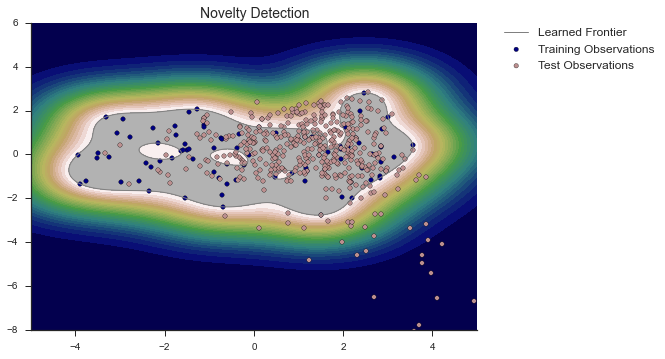

In [148]:
# create a mesh to plot in
x_min, x_max = train_2d[:, 0].min() - 2, train_2d[:, 0].max() + 2
y_min, y_max = train_2d[:, 1].min() - 6, train_2d[:, 1].max() + 4
# step size in the mesh
h = 0.05 
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svm_model_2d.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection", {'fontsize': 14})

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 30), cmap=plt.cm.gist_earth)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=1, colors='grey')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='grey', alpha=0.6)

b1 = plt.scatter(train_2d[:, 0], train_2d[:, 1], c='navy') # train set
b2 = plt.scatter(test_2d[:, 0], test_2d[:, 1], c='rosybrown') # test set
plt.xlim((-5, 5))
plt.ylim((-8, 6))
plt.legend([a.collections[0], b1, b2],
           ["Learned Frontier", "Training Observations",
            "Test Observations"], bbox_to_anchor=(1.05, 1), borderaxespad=0.,
           loc=2,
           prop=matplotlib.font_manager.FontProperties(size=12))
sns.despine()
plt.show()

This plot shows how One-Class SVM algorithm made decision about which side of the boundary each track lays on. On the plot, 301 tracks lay within the boundary and 143 tracks were left outside. When applied to the full 11-dimensional dataset, the result is a bit different. 289 tracks in the test set match the training, or labeled, data, and 155 tracks don't. 

In the following posts I'm going to work with these 289 tracks that were identified by One-Class SVM algorithm as a good match to the three classes. I record the result of novelty detection algorithm to the test set and then save on disk. Thus it will be more convenient to load data in the future posts, avoiding most pre-processing steps.  

In [149]:
# add novelty results to the set
# convert test_novelty_pred from a 1d array into a 2d array
print ('Shape before: {}, number of dimensions: {}'
        .format(test_novelty_pred.shape, test_novelty_pred.ndim))
print ('Shape after the magic: {}, number of dimensions: {}'
       .format(test_novelty_pred[:, None].shape, test_novelty_pred[:, None].ndim))

Shape before: (444,), number of dimensions: 1
Shape after the magic: (444, 1), number of dimensions: 2


In [150]:
# create new array with results
test_svm = np.concatenate((test_std, test_novelty_pred[:, None]), 1)
print "Test set shape before concatenation:", test_std.shape
print "Test set shape after concatenation:", test_svm.shape

Test set shape before concatenation: (444, 11)
Test set shape after concatenation: (444, 12)


In [151]:
# list column names for the DF
cols = test_df.select_dtypes(exclude=[object]).columns.tolist()

In [152]:
# make new DF with the result of novelty detection
test_svm = pd.DataFrame(test_svm, columns=[cols+['match']])
test_svm.sample(5)

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence,match
9,-0.75,0.23,-0.55,-0.53,1.26,-0.82,-1.17,0.82,-1.52,0.43,0.41,1.00
429,-0.70,0.69,-0.03,-0.51,-1.66,1.15,0.85,-0.76,-0.71,0.43,-0.09,1.00
440,-1.21,1.89,0.35,-0.52,-1.66,0.79,0.85,-0.89,0.06,0.43,1.01,-1.00
18,-0.96,1.03,1.35,-0.56,1.55,1.13,0.85,-0.92,-0.55,0.43,0.03,-1.00
267,-0.99,2.18,0.27,0.56,1.26,0.71,-1.17,0.07,-0.11,0.43,1.31,1.00


### Save data with HDF5
Looking through the Pandas documentation, I came across HDF5. HDF5 allows to treat a local file as a hash and work directly with DataFrames. Very cool. It's trivial to read and write from this file using Pandas.  

I save the standardized training and test set with novelty detection results on disk in the table format. Conceptually a table is shaped very much like a DataFrame, with rows and columns. A table may be appended to in the same or other sessions. In addition, delete & query type operations are supported.

In [153]:
# save test df 
test_svm.to_hdf('music_data.h5', 'test_svm', format='table')

In [154]:
# convert training set back to DF
train_std_df = pd.DataFrame(train_std, columns=cols)

# save training df
train_std_df.to_hdf('music_data.h5', 'train_std', format='table')

# check the result
print pd.HDFStore('music_data.h5')

<class 'pandas.io.pytables.HDFStore'>
File path: music_data.h5
/test_svm             frame_table  (typ->appendable,nrows->444,ncols->12,indexers->[index])
/train_std            frame_table  (typ->appendable,nrows->88,ncols->11,indexers->[index]) 


## Novelty detection by one class
As an experiment, I'm going to provide One-Class SVM algorithm not with the whole training data but only with one class at a time. Thus the algorithm will choose in the test set only those observations that match that particular class. In the following notebooks I will compare the result of this approach with ML classification algorithms.

#### Data preparation

In [155]:
# labels are stored in a separate array
target = prs.target_to_numerical_format(train_df)

# make Numpy arrays for each class
ballet = prs.convert_df_to_array(train_std_df[target == 0])
cycling = prs.convert_df_to_array(train_std_df[target == 1])
yoga = prs.convert_df_to_array(train_std_df[target == 2])

#### One-Class SVM algorithm — 'ballet' class

In [156]:
def new_observations_by_class(model, data):
    """Identify matching observations
    in the test set.
    Return a Numpy array where
    inliers are 1, outliers are -1. 
    """
    # clone the model
    model_c = clone(model)
    
    # fit the model
    model_c.fit(data)
    
    # make prediction
    novelty = model_c.predict(test_std)
    
    return novelty

def novelty_detection_summary(novelty, label):
    # number of tracks within boundaries
    n = novelty[novelty == 1].size

    # number of tracks outside set boudaries
    n_error = novelty[novelty == -1].size

    print ("Number of tracks that match the {0} class: {1}."
           "\nNumber of tracks outside the class boudaries: {2}."
           .format(label, n, n_error))

In [157]:
# make prediction
nov_ballet = new_observations_by_class(svm_model, ballet)

# print the result
novelty_detection_summary(nov_ballet, 'ballet')

Number of tracks that match the ballet class: 67.
Number of tracks outside the class boudaries: 377.


#### One-Class SVM algorithm — 'cycling' class

In [160]:
# make prediction
nov_cycling = new_observations_by_class(svm_model, cycling)

# print the result
novelty_detection_summary(nov_cycling, 'cycling')

Number of tracks that match the cycling class: 120.
Number of tracks outside the class boudaries: 324.


#### One-Class SVM algorithm — 'yoga' class

In [161]:
# make prediction
nov_yoga = new_observations_by_class(svm_model, yoga)

# print the result
novelty_detection_summary(nov_yoga, 'yoga')

Number of tracks that match the yoga class: 24.
Number of tracks outside the class boudaries: 420.


In [164]:
print ("Sum of all new observations equals to {}."
       .format(nov_ballet[nov_ballet == 1].size + 
               nov_cycling[nov_cycling == 1].size + 
               nov_yoga[nov_yoga == 1].size))

Sum of all new observations equals to 211.


#### Plot

## Summary
In this notebook I applied One-Class SVM algorithm to identify tracks in the unlabeled dataset that fit classes in the training dataset and eliminate tracks that completely unfit the classes. As a result, 288 tracks were chosen from the test set as matching the training set. In the following notebooks I will apply different machine learning classification algorithms to label 288 tracks with one of the three classes — "cycling", "ballet", and "yoga".